# Introduction: Retail Revenue Prediction

In this project, you will predict the revenues of retail stores across all of Norway.

We have been given a large dataset by [Plaace](https://plaace.co/en/), a Norwegian company that matches businesses to retail properties. They have provided us with revenue information for over 20,000 retail stores that will be used to train and evaluate your models. In addition, we have also been provided with a wide selection of supplementary data that can be used to engineer more powerful features, including geo-specific demographic, public transportation information, a hierarchical grouping of the stores, and information about over 28,000 additional stores.

**You may only use the data provided here for your models.** We have made this rule based on experience from previous years to ensure a fair and accurate grading.

This notebook aims to provide you with an introduction to the data. In addition, we give a short tutorial on how to generate and upload a Kaggle submission file. 

## Basics 

We begin by giving a quick overview of the data you've been given, presenting the training and testing set, and introducing the formula we will use to evaluate prediction performance.

### Directory Structure

You are given a collection of comma separated values (csv) files to work with. The two most important files are `stores_train.csv` and `stores_test.csv` which will be covered shortly. The remaining files contain supplementary data that are likely to be useful for crafting a richer feature set. They will be covered later in this notebook.

In [3]:
!ls ./data | sort

busstops_norway.csv
grunnkrets_age_distribution.csv
grunnkrets_households_num_persons.csv
grunnkrets_income_households.csv
grunnkrets_norway_stripped.csv
plaace_hierarchy.csv
sample_submission.csv
stores_extra.csv
stores_test.csv
stores_train.csv


### Train Stores

The `stores_train.csv` dataset is the basis for your training data and contains 12859 rows. 
Each store (row) is associated with the following information:
- `store_id`: unique ID for each store 
- `year`: The year the data is recorded for (should all be 2016)
- `store_name`: Human readable name for each store
- `plaace_hierarchy_id`: Group ID for the store type (see [Place Hierarchy](#Plaace-Hierarchy))
- `sales_channel_name`: Human readable name for the store type 
- `grunnkrets_id`: Geographical ID for the store's location (see [Grunnkrets Data](#Grunnkrets-Data))
- `address`: Street address of the store 
- `lat`: Latitude (north-south) coordinate for the store's location 
- `lon`: Longitude (west-east) coordinate for the store's location 
- `chain_name`: Name of the chain the store belongs to (if available)
- `mall_name`: Name of the mall a store is located in (if available)
- `revenue` (**target**): The store's revenue in 2016. This is what you will be predicting.

In [4]:
import pandas as pd
stores_train = pd.read_csv('data/stores_train.csv')
stores_train.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528


### Test Stores

The dataset with test stores consists of 8577 rows. Note that it contains the exact same columns as the train set stores, except that the `revenue` column is missing. Your grade in this project will mainly be based on how well you can predict these missing values.

In [5]:
stores_test = pd.read_csv('data/stores_test.csv')
stores_test.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name
0,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,NaN
1,916789157-916823770-824309,2016,BURGER KING MYREN,1.1.1.0,Hamburger restaurants,8061401,MYREN 1,59.201467,9.588243,BURGER KING,NaN
2,913341082-977479363-2948,2016,BURGER KING STOVNER,1.1.1.0,Hamburger restaurants,3013917,STOVNER SENTER 3,59.962146,10.924524,BURGER KING,Stovner Senter
3,889682582-889697172-28720,2016,BURGER KING TUNGASLETTA,1.1.1.0,Hamburger restaurants,16012104,TUNGASLETTA 16,63.420785,10.461091,BURGER KING,NaN
4,997991699-998006945-417222,2016,VULKAN BURGERBAR,1.1.1.0,Hamburger restaurants,3014305,AUD SCHØNEMANNS VEI 15,59.921102,10.785123,VULKAN BURGERBAR,NaN


### Objective 

Because we consider the revenue a continuous variable, we call this a _regression_ problem. It is common to evaluate regression problems according to some deviation measure of the error (difference) between the predictions and the ground truth values. Typical choices are Mean Squared Error (MSE) and its square root, the Root Mean Squared Error (RMSE).

However, both of these measures are quite sensitive to extreme values and work best if the typical scale of prediction errors are consistent across the dataset. This is not likely to be the case here because the revenue variable varies a lot. This means that a, say 10%, prediction error would matter a lot more if it is for one of the higher-earning stores than for one of the lower-earning ones. Consequently, we will use a variation that takes a log transform of the target variable before computing prediction errors.

**TL;DR**: submissions for this problem will be evaluated according to the `Root Mean Squared Log Error` (RMSLE):

- $\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(1 + \hat{y}_i) - \log(1 + y_i))^2}$

In the equation above, $y_i$ corresponds to the ground truth value for datapoint $i$, $\hat{y}_i$ corresponds to the predicted value for datapoint $i$, and $n$ denotes the total number of datapoints (dimensionality of $y$, $\hat{y}$). See the cell below for an implementation.



In [6]:
import numpy as np 

def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))



# Calculate rmsle for a few example predictions 
y_true = stores_train.revenue.values
n = len(stores_train)
print('A couple of RMSLE scores computed over the train set')
print(f'Perfect prediction: {rmsle(y_true, y_true):.4f}')
print(f'All zeros prediciton: {rmsle(y_true, np.zeros(n)):.4f}')
print(f'All ones prediction: {rmsle(y_true, np.ones(n)):.4f}')

A couple of RMSLE scores computed over the train set
Perfect prediction: 0.0000
All zeros prediciton: 1.8900
All ones prediction: 1.3606


## Supplementary Data 

The following sections cover the remaining data at your disposal.

### Extra Stores 

The extra stores dataset is a collection of stores for which we had no revenue data. Structurally, it is identical to the test set, but you are naturally not expected to submit any predictions for it. You can, however, use the additional data in your analysis, in unsupervised methods you might employ, or to provide a stronger data basis for missing value imputation.


In [7]:
stores_extra = pd.read_csv('data/stores_extra.csv')
stores_extra.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name
0,911669196-973140302-27020,2016,BURGER KING STRANDGATEN,1.1.1.0,Hamburger restaurants,12010115,STRANDGATEN 5,60.393979,5.323851,BURGER KING,NaN
1,913155726-992998792-5832,2016,BURGER KING JESSHEIM STORSENTER,1.1.1.0,Hamburger restaurants,2350205,STORGATA 6,60.142760,11.171834,BURGER KING,Jessheim Storsenter
2,988252905-981108604-47887,2016,BURGER KING LANGNES,1.1.1.0,Hamburger restaurants,19020419,HULDERVEGEN 6,69.671483,18.920483,BURGER KING,NaN
3,995194546-891354622-45262,2016,BURGER KING MAGNETEN LEVANGER,1.1.1.0,Hamburger restaurants,17190701,NaN,63.732791,11.281785,BURGER KING,Magneten
4,881339692-979954964-3203,2016,BURGER KING ULLEVAAL STADION,1.1.1.0,Hamburger restaurants,3014511,SOGNSVEIEN 75,59.948558,10.732823,BURGER KING,Amfi Ullevaal


### Plaace Hierarchy 

Plaace has provided us with their system for sorting stores into categories in a 4-level hierarchy. The top level of the hierarchy contains the most abstract groupings ("Dining and Experiences", "Retail", and "Services"). As you move further down in the hierarchy, you get more and more specific categories (109 distinct values at level 4).

Each store is associated with a dot-separated `plaace_hierarchy_id`, which gives its group membership at all four levels of the hierarchy. For instance, the id "2.8.11.2" gives groups "Retail" -> "Food and drinks" -> "Alcohol sales" -> "Beer and soda shop". 

In the cell below we use the `pd.DataFrame.merge` method to perform a left join between the train store data and the hierarchy data, using the `plaace_hierarchy_id` as join key. The result is that each train store row gets corresponding place hierarchy information appended to its side (we just visualize the table vertically to make it easier to see all the columns).

In [20]:
# Read plaace_hierarchy data 
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')

# Augment stores_train with information about the hierarchy
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

# Show dataframe, but transposed so that we can more easily see all the resulting columns
stores_with_hierarchy.head().T
stores_with_hierarchy.head()
plaace_hierarchy

stores_with_hierarchy_train = stores_with_hierarchy
stores_with_hierarchy_test = stores_test.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
stores_with_hierarchy_test
stores_with_hierarchy_train


,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,mall_name,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc
0,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
1,916789157-916823770-824309,2016,BURGER KING MYREN,1.1.1.0,Hamburger restaurants,8061401,MYREN 1,59.201467,9.588243,BURGER KING,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
2,913341082-977479363-2948,2016,BURGER KING STOVNER,1.1.1.0,Hamburger restaurants,3013917,STOVNER SENTER 3,59.962146,10.924524,BURGER KING,Stovner Senter,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
3,889682582-889697172-28720,2016,BURGER KING TUNGASLETTA,1.1.1.0,Hamburger restaurants,16012104,TUNGASLETTA 16,63.420785,10.461091,BURGER KING,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
4,997991699-998006945-417222,2016,VULKAN BURGERBAR,1.1.1.0,Hamburger restaurants,3014305,AUD SCHØNEMANNS VEI 15,59.921102,10.785123,VULKAN BURGERBAR,NaN,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8572,917323003-917383529-844309,2016,GULATING HAUGESUND,2.8.11.2,Beer and soda shop,11490601,BRÅTAVEGEN 30,59.259575,5.325813,GULATING GRUPPEN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop
8573,917353379-917411824-845904,2016,STAVANGER BEER AS,2.8.11.2,Beer and soda shop,11030901,SANDVIGÅ 7,58.976219,5.721546,NaN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop
8574,917072302-917089248-833647,2016,GULATING ØLUTSALG OG PUB,2.8.11.2,Beer and soda shop,2270103,GARDERBAKKEN 6,59.928330,11.163202,GULATING GRUPPEN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop
8575,916960557-916993161-829908,2016,VI BRYGGER BUTIKKDRIFT AS,2.8.11.2,Beer and soda shop,12470701,RAVNANGERVEGEN,60.445790,5.161587,NaN,NaN,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop


### Grunnkrets Data 

Next follows information about different regions in Norway and their demography.
A "[Grunnkrets](https://no.wikipedia.org/wiki/Grunnkrets)" is a type of statistical unit used to describe a small geographic area. The corresponding term in english is "[Basic statistical unit](https://en.wikipedia.org/wiki/Basic_statistical_unit_(Norway))".

We have a total of four extra datasets that provides extra information about the different grunnkrets units in Norway: One describing the grunnkrets itself and three describing its demographics.

All the grunnkrets datasets have a column called `grunnkrets_id`. A corresponding column can be found in the `stores_*` datasets, meaning that you can augment each store with information about the grunnkrets it is located in using similar join logic as the `merge` operation used in the previous section.

Note that we have grunnkrets-related data for both 2015 and 2016, but keep in mind that the revenue predictions you will make are all for 2016. Moreover, the demography data is actually for the district, but has already been mapped to each grunnkrets for us.

#### Geography

The first grunnkrets dataset we will look at describes the geography of each grunnkrets. In addition to the official name of the grunnkrets, we also have the district the grunnkrets is located in, as well as the municipality the district is located in. 

Finally, we also have a polygon describing the geographical area covered by the grunnkrets. If you want to process this data further, we recommend you check out the [geopandas](https://geopandas.org) extension. The area of the polygon (in square kilometers) is already computed and available for you to use.

In [21]:
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets.head()

stores_with_hierarchy_grunnkrets_test = stores_with_hierarchy_test.merge(grunnkrets, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_train = stores_with_hierarchy_train.merge(grunnkrets, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_test
stores_with_hierarchy_grunnkrets_train

,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,...,lv3,lv3_desc,lv4,lv4_desc,year_y,grunnkrets_name,district_name,municipality_name,geometry,area_km2
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,...,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2015.0,Bragernes sentrum 3,Bragernes sentrum,Drammen,"POLYGON((10.2046156903846 59.7447808519649, 10...",0.155779
1,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,...,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2016.0,Bragernes sentrum 3,Bragernes sentrum,Drammen,"POLYGON((10.2046156903846 59.7447808519649, 10...",0.155779
2,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,...,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2015.0,Sentrum 3 /rode 6,Sentrum 3,Oslo,"POLYGON((10.7303654475615 59.9107195782207, 10...",0.264278
3,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,...,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2016.0,Sentrum 3 /rode 6,Sentrum 3,Oslo,"POLYGON((10.7303654475615 59.9107195782207, 10...",0.264278
4,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,...,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants,2015.0,Sydsiden 2,Hønefoss,Ringerike,"POLYGON((10.2654039198422 60.1639238060368, 10...",0.160152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25683,911721961-911764474-496764,2016,GULATING ØLUTSALG STRØMMEN,2.8.11.2,Beer and soda shop,2310803,STØPERIVEIEN 6,59.946562,11.007659,GULATING GRUPPEN,...,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,2016.0,Stalsberg 3,Stalsberg,Skedsmo,"POLYGON((11.0040997448376 59.9483583629928, 11...",0.123431
25684,914337046-914343372-721294,2016,DET GODE BRYGG,2.8.11.2,Beer and soda shop,11020113,VÅGSGATA 16,58.850261,5.735674,NaN,...,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,2015.0,Vågsgate,Sentrum,Sandnes,"POLYGON((5.7342552469665 58.8492193600012, 5.7...",0.034857
25685,914337046-914343372-721294,2016,DET GODE BRYGG,2.8.11.2,Beer and soda shop,11020113,VÅGSGATA 16,58.850261,5.735674,NaN,...,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,2016.0,Vågsgate,Sentrum,Sandnes,"POLYGON((5.7342552469665 58.8492193600012, 5.7...",0.034857
25686,917494436-917551936-851089,2016,TROMSØ BRYGGERIUTSALG AS,2.8.11.2,Beer and soda shop,19021302,PLANETVEGEN 10,69.670422,19.042659,NaN,...,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop,2016.0,Lunheimblokkene,Tomasjord,Tromsø,"POLYGON((19.0381759322038 69.6681850526244, 19...",0.204915


#### Age Distribution

Next, we have information about the age distribution in different grunnkrets units. Each column gives the number of people of a given age that lives in the grunnkrets. For instance, the `12` in the first row of column `age_6` means that there are 12 six-year-olds in the corresponding grunnkrets.

In [22]:
grunnkrets_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
grunnkrets_ages.head()

stores_with_hierarchy_grunnkrets_age_train = stores_with_hierarchy_grunnkrets_train.merge(grunnkrets_ages, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_test = stores_with_hierarchy_grunnkrets_test.merge(grunnkrets_ages, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_train
stores_with_hierarchy_grunnkrets_age_test

,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,...,age_81,age_82,age_83,age_84,age_85,age_86,age_87,age_88,age_89,age_90
0,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,916789157-916823770-824309,2016,BURGER KING MYREN,1.1.1.0,Hamburger restaurants,8061401,MYREN 1,59.201467,9.588243,BURGER KING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33216,916960557-916993161-829908,2016,VI BRYGGER BUTIKKDRIFT AS,2.8.11.2,Beer and soda shop,12470701,RAVNANGERVEGEN,60.445790,5.161587,NaN,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0
33217,987280891-972040746-45320,2016,KROKEN ØL OG MINERALVANN ANS,2.8.11.2,Beer and soda shop,8170207,NaN,59.097903,9.055490,NaN,...,11.0,11.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0,5.0
33218,987280891-972040746-45320,2016,KROKEN ØL OG MINERALVANN ANS,2.8.11.2,Beer and soda shop,8170207,NaN,59.097903,9.055490,NaN,...,11.0,11.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0,5.0
33219,987280891-972040746-45320,2016,KROKEN ØL OG MINERALVANN ANS,2.8.11.2,Beer and soda shop,8170207,NaN,59.097903,9.055490,NaN,...,11.0,11.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0,5.0


#### Household Types 

The second demography dataset gives the household composition in each grunnkrets. The different types of households are partitioned into 8 categories. Each column gives the number of households in a given category.

In [23]:
grunnkrets_household_types = pd.read_csv('data/grunnkrets_households_num_persons.csv')
grunnkrets_household_types.head()

stores_with_hierarchy_grunnkrets_age_hhtype_train = stores_with_hierarchy_grunnkrets_age_train.merge(grunnkrets_household_types, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtype_test = stores_with_hierarchy_grunnkrets_age_test.merge(grunnkrets_household_types, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtype_train
stores_with_hierarchy_grunnkrets_age_hhtype_test

/usr/lib/python3/dist-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'year_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


,store_id,year_x,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,...,age_90,year_y,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles
0,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,...,0.0,2015.0,264.0,41.0,138.0,176.0,34.0,13.0,48.0,296.0
1,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,...,0.0,2016.0,251.0,47.0,140.0,166.0,26.0,20.0,68.0,293.0
2,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,...,0.0,2015.0,264.0,41.0,138.0,176.0,34.0,13.0,48.0,296.0
3,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,...,0.0,2016.0,251.0,47.0,140.0,166.0,26.0,20.0,68.0,293.0
4,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,...,0.0,2015.0,264.0,41.0,138.0,176.0,34.0,13.0,48.0,296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66232,987280891-972040746-45320,2016,KROKEN ØL OG MINERALVANN ANS,2.8.11.2,Beer and soda shop,8170207,NaN,59.097903,9.055490,NaN,...,5.0,2016.0,233.0,75.0,249.0,274.0,29.0,32.0,82.0,301.0
66233,987280891-972040746-45320,2016,KROKEN ØL OG MINERALVANN ANS,2.8.11.2,Beer and soda shop,8170207,NaN,59.097903,9.055490,NaN,...,5.0,2015.0,243.0,71.0,248.0,270.0,47.0,39.0,60.0,294.0
66234,987280891-972040746-45320,2016,KROKEN ØL OG MINERALVANN ANS,2.8.11.2,Beer and soda shop,8170207,NaN,59.097903,9.055490,NaN,...,5.0,2016.0,233.0,75.0,249.0,274.0,29.0,32.0,82.0,301.0
66235,987280891-972040746-45320,2016,KROKEN ØL OG MINERALVANN ANS,2.8.11.2,Beer and soda shop,8170207,NaN,59.097903,9.055490,NaN,...,5.0,2015.0,243.0,71.0,248.0,270.0,47.0,39.0,60.0,294.0


#### Household Income

The last demography dataset gives median incomes in each grunnkrets. The first income column is `all_households`, which denotes the median income aggregated across all households in the grunnkrets. The last three columns further breaks this figure down for three different types of households.

In [26]:
grunnkrets_household_income = pd.read_csv('data/grunnkrets_income_households.csv')
grunnkrets_household_income.head()

stores_with_hierarchy_grunnkrets_age_hhtype_income_train = stores_with_hierarchy_grunnkrets_age_hhtype_train.merge(grunnkrets_household_income, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtype_income_test = stores_with_hierarchy_grunnkrets_age_hhtype_test.merge(grunnkrets_household_income, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtype_income_train
stores_with_hierarchy_grunnkrets_age_hhtype_income_test

stores_merged_train = stores_with_hierarchy_grunnkrets_age_hhtype_income_train
stores_merged_test = stores_with_hierarchy_grunnkrets_age_hhtype_income_test

### Busstops

Lastly, we also have information about bus stops all over Norway. Unlike the previous datasets, none of the rows here are directly associated with any of the stores. However, the `geometry` column contains information about the location, which can be compared with the location of stores to generate features.

- `busstop_id`: unique ID for busstop. Not tied to anything else in this dataset 
- `stopplace_type`: what kind of stop it is (e.g. just a curbside stop or a proper bus pocket)
- `importance_level`: how important the stop is (e.g. just a regular stop or a regional hub)
- `side_placement`: position in the road 
- `geometry`: latitude and longitude of location (point geometry)

In [13]:
busstops = pd.read_csv('data/busstops_norway.csv')
busstops.head()

,busstop_id,stopplace_type,importance_level,side_placement,geometry
0,853cb081-cc32-4880-aa3e-26e96870d874,Plattform og lomme,Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(6.54064723379766 61.0618887850553)
1,156b052b-2771-497a-b4f4-97fed59e1aca,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(5.89980086113255 60.1421872817075)
2,7312a280-e14f-4b09-a421-02e8fe1bc63e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781327278563 59.9299988828761)
3,d9cda2c7-355a-49c1-b56c-a33180d2a82e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781496457324 59.9301044643692)
4,f803bcd3-182d-450b-bbb4-113c6ca885c2,NaN,Mangler viktighetsnivå,MIDDLE_RIGHT,POINT(10.7781676444854 59.9302099995898)


## Getting Started

In this final section, we will go through a sped-up and simplified version of the work we expect you to do; all the way from initial EDA, to "training" a very simple model, and finally using the model to make a submission with test set predictions.

### Analyzing the Data

The first thing you should do is start exploring the data. We often refer to this activity as Exploratory Data Analysis (EDA). In the cell below we make two plots. The first one shows the number of missing values in the `stores_train` dataframe. The second one visualizes the distribution of the target variable (revenue).

In your own work, you should go a lot further than this. You may for instance want to:

- Look for outliers and other parts of the data that should be cleaned up
- Investigate to what degree single variables correlate, both with each other and the target variable
- Visualize different variables spatially, perhaps with maps in the background



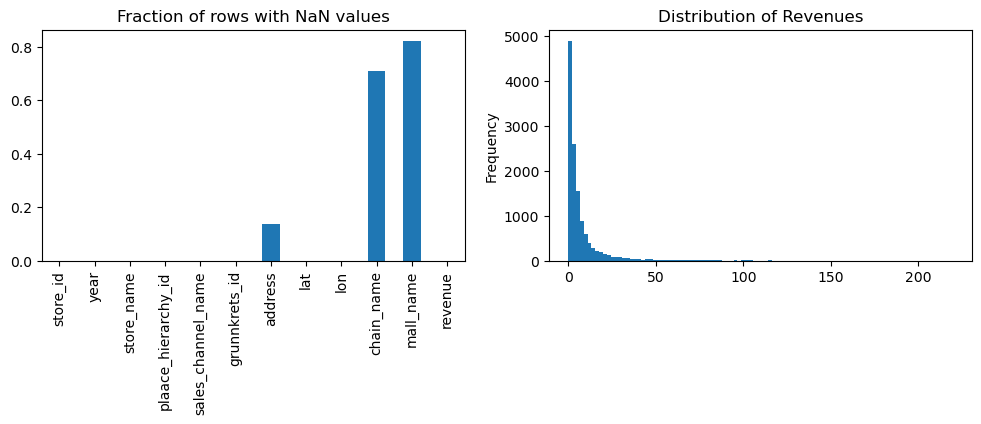

In [14]:
import matplotlib.pyplot as plt 

fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), ncols=2)
stores_train.isna().mean().plot.bar(ax=ax1)
ax1.set_title('Fraction of rows with NaN values')
stores_train.revenue.plot.hist(bins=100, ax=ax2)
ax2.set_title('Distribution of Revenues');

In [37]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import xgboost as xgb


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# Predict on the test set 
X_test = stores_test  
y_test_pred = model.predict(X_test)

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = X_test.store_id 
submission['predicted'] = np.asarray(y_test_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
submission

### Building a Model

Next, we design and train a model. To avoid giving away a solution that will beat the worst virtual teams, the cell below implements an exceptionally bad model. All it does is fitting a uniform distribution based on the minimum and maximum y-values (revenues) in the training set. When making predictions, it simply samples the uniform distribution while completely disregarding any features.

In [15]:
class ReallyBadRandomGuesser:
    """
    Model that fits a uniform distribution to the minimum and 
    maximum observed y-values in the training set.
    
    Args:
        random_seed (int): Seed for the random distribution used to 
            sample predictions.
    """
    
    def __init__(self, random_seed=None):
        self.random = np.random.RandomState(random_seed)
    
    def fit(self, X, y):
        # Store min/max values of train set y values 
        self.y_min = y.min()
        self.y_max = y.max()
    
    def predict(self, X):
        n = len(X)
        return self.random.uniform(self.y_min, self.y_max, size=n)

# Partition into X (not really used here) and y values 
X_train = stores_train.drop(columns=['revenue'])
y_train = stores_train.revenue 

# Create and fit a model 
model = ReallyBadRandomGuesser(random_seed=123)
model.fit(X_train, y_train)

# Generate predictions over the training set 
y_train_pred = model.predict(X_train)

print(f'Train set RMSLE: {rmsle(y_train, y_train_pred) :.4f}')

Train set RMSLE: 3.1491


### Creating a Submission

Finally, we used the "trained" model to make predictions on the test set and turn it into a submission for kaggle. The format for submissions is a simple csv file with two columns; one for the store id and one for the predicted revenue.
An example of what the start of the file should look like can be seen below:


```
id,predicted
914206820-914239427-717245,181.66162783399506
916789157-916823770-824309,206.81469433388355
913341082-977479363-2948,83.49386666841214
...
```

Keep in mind the following when generating predictions:
- Make sure that the csv  <id, predicted> columns.
- Make sure that the ID values correctly correspond to each prediction. 
- Make sure there are no negative, nan, or other non-numeric values in your submission 


In [16]:
# Predict on the test set 
X_test = stores_test  
y_test_pred = model.predict(X_test)

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = X_test.store_id 
submission['predicted'] = np.asarray(y_test_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('sample_submission.csv', index=False)
submission

,id,predicted
0,914206820-914239427-717245,154.794199
1,916789157-916823770-824309,65.910432
2,913341082-977479363-2948,125.734833
3,889682582-889697172-28720,186.674469
4,997991699-998006945-417222,52.835612
...,...,...
8572,917323003-917383529-844309,111.751372
8573,917353379-917411824-845904,14.144024
8574,917072302-917089248-833647,36.285822
8575,916960557-916993161-829908,61.355667


### Uploading to Kaggle


Once a submission csv has been created, it can be uploaded to Kaggle. If you haven't already, you can enroll in the Kaggle competition by following [this special link](https://www.kaggle.com/t/3affe88e40c44dde87d1ff836ded9e92) along with the rest of your teammates.

You can upload submissions manually through the competition web page [as explained here](https://www.kaggle.com/docs/competitions#submitting-predictions). 


Alternatively, you can use the Kaggle API ([see here for installation instructions](https://github.com/Kaggle/kaggle-api)) and do it from the terminal with the following command template:

```bash
kaggle competitions submit tdt4173-2022-project2 -f <filepath> -m "<message>"
```

Where `<filepath>` in this case would be `./sample_submission.csv` and `<message>` is your own comment for the submission.

Note that your prediction performance on the test set is broken down into two parts; a `public` and a `private` one. When you upload a submission, you will immediately be able to see your public score, which is computed over a subset of the test set rows. The private score is calculated over the remaining datapoints and will not be visible until the end of the project, but is what ultimately determines the score-based part of your grade.

There is a limit to the maximum number of submissions you can submit on Kaggle each day (5 at the time of writing). Keep this in mind when submitting, but don't hesitate to use all your submissions every day; they will provide you with feedback and renew each new day.

## Next Steps

- Plot, summarize, and get familiar with the dataset. If you have any questions, don't hesitate to ask the course staff. If we don't know the answer, we can try to reach out to the data scientists at Plaace. Don't be surprised if you find the dataset to be a bit noisy. Like most real-world datasets, it is aggregated from many imperfect (and sometimes contradictory) sources.

- Try to make some very simple models. How well does a simple mean estimate do? Can you improve on the mean by including information from a single feature? Do any variables have simple, linear relationships with the revenue? Can you make the relationships (more) linear? In addition to getting you more familiar with the dataset, making simple models establishes baselines that can be used to reason about more complex approaches later.

- Try to apply different machine learning algorithms. The [Scikit-Learn](https://scikit-learn.org/stable/) package is a good starting point that contains stable implementations of many popular algorithms. In addition, we recommend you look into gradient boosting algorithms such as [xgboost](https://xgboost.readthedocs.io/en/stable/), [catboost](https://catboost.ai/), and [lightgbm](https://lightgbm.readthedocs.io/en/v3.3.2/). Keep in mind that as you start applying more complex learning algorithms, you start running the risk of overfitting and may need to use validation data to tune hyperparameters. 

- As you start to get several decent models, start thinking about ensembling them. This will typically allow you to squeeze out a bit more performance. In general, an ensemble works better if the individual member models make uncorrelated errors. Different algorithms, features, and even hyperparameters tend to lead to uncorrelated errors.

- Feel free to draw inspiration from others online, just adapt the solutions you find to the problem at hand and make sure you understand it. The Kaggle platform is a goldmine in this regard and contains tutorial notebooks on everything from [basic data science](https://www.kaggle.com/code/kanncaa1/data-sciencetutorial-for-beginners), [general machine learning](https://www.kaggle.com/code/kanncaa1/machine-learning-tutorial-for-beginners/notebook), and [boosting](https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression/notebook). 